# 분류기(Classifier)학습하기

## st1. 데이터에 관하여
일반적으로 이미지나 텍스트, 오디오, 비디오데이터의 경우 파이썬 라이브러리를 이용하여 numpy배열로 불러와서 학습한다.
* 이미지 : pillow, openCV
* 오디오 : scipy, LibROSA
* 텍스트 : python, Cython, NLTK, SpaCy

## st2. 이미지 분류기 학습
torchision을 이용하여 분류기 학습
1. CIFAR10 불러와 정규화
2. NN정의
3. Loss 정의
4. training
5. testing

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size,
    shuffle=True, num_workers=2
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,
    shuffle=False, num_workers=2
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2-1. 이미지확인
loader에서 데이터를 가져오려면, iter, next를 써야한다.

torch.Size([4, 3, 32, 32])
torch.Size([3, 36, 138])


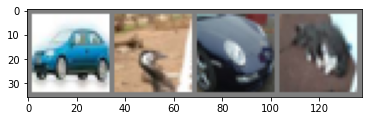

car bird car cat


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # tensor to np
#     plt.imshow(np.transpose(npimg, (1,2,0)))
#     print(npimg.shape)
    # np.transpose : torch.permute()와 같음. 차원 교환
#     print(np.transpose(npimg, (1, 2, 0)).shape)  # (3, 36, 138) to (36, 138, 3)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape) # [4, 3, 32, 32]
# 배치 이미지를 grid를 몇 pixel을 넣어주고 한줄로 생성
print(torchvision.utils.make_grid(images).shape) # (3, 36, 138)
imshow(torchvision.utils.make_grid(images))

# label 출력
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

### 2-2 CNN정의 및 loss, optimizer 정의

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

### 2-3 training

In [5]:
for epoch in range(2):
    runing_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        runing_loss += loss.item()
        
        if i % 2000 == 1999: # 매 2000 미니 배치마다.
            print(f'epoch{epoch + 1}, {i + 1:5d} loss: {runing_loss/2000:.3f}')
            runing_loss = 0.0 # 다시 초기화
                  
print('학습종료')
                  

epoch1,  2000 loss: 2.141
epoch1,  4000 loss: 1.798
epoch1,  6000 loss: 1.676
epoch1,  8000 loss: 1.558
epoch1, 10000 loss: 1.493
epoch1, 12000 loss: 1.459
epoch2,  2000 loss: 1.387
epoch2,  4000 loss: 1.362
epoch2,  6000 loss: 1.296
epoch2,  8000 loss: 1.274
epoch2, 10000 loss: 1.264
epoch2, 12000 loss: 1.254
학습종료


### 2-4 model saving
weight, bias를 `torch.save()`로 저장

In [6]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## st3. Testing
* test 이미지와 정답셋을 비교하는 방식으로 확인
* 저장한 모델을 불러와 예측값 확인
* 모델 불러오기는 다음의 과정:
  * weight 불러오기 : `torch.load()`
  * model구조에 덮어쓰기 : `model.load_state_dict()`
* classification은 class갯수만큼의 output생성됨. -> onehot to index과정 필요
  * `torch.max()` 를 이용

### 3-1. 첫 배치로만 확인

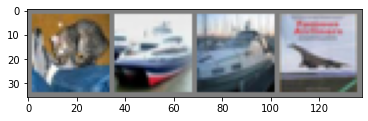

GT:  cat ship ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print(f'GT: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [13]:
# 저장한 모델을 불러와 예측값 확인
load_net = Net()
load_net.load_state_dict(torch.load(PATH))

outputs = load_net(images)
print(outputs.shape)   # (4, 10)

# one hot to index
# print(torch.max(outputs, 1))   # max의 (실제값, index) 출력됨.
_, predicted = torch.max(outputs, 1)  # index만 필요
print(predicted)



torch.Size([4, 10])
tensor([3, 8, 8, 0])


In [15]:
print(f'Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

Predicted:  cat ship ship plane


결과가 좋음

### 3-2. test 전체 데이터셋으로 정확도 확인
accuracy 확인한다. : 맞은 갯수 / 전체 갯수

In [17]:
correct = 0    # 맞춘 갯수
total_cnt = 0  # 전체 샘플 갯수

with torch.no_grad(): ## gradient 계산 비활성화 : requires_grad=False 와 같아짐
    for data in testloader:
        images, labels = data
        outputs = load_net(images)
        _, predicted = torch.max(outputs, 1)
        total_cnt += labels.size(0)  # 배치안의 샘플 갯수를 더 한다.
        correct += (predicted == labels).sum().item()

print(f'Accuracy for 10,000 test images: {100 * correct // total_cnt}%')

Accuracy for 10,000 test images: 55%


* 결과가 크게 좋진 못함. 무작위로 찍었다면 정확도는 10%가 나올것임.

### 3-3 각 클래스 별로 정확도 산출

In [22]:
# 각 클래스별 수집을 위해 dict로 생성
correct_dict = {classname: 0 for classname in classes}
total_cnt_dict = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = load_net(images)
        _, predicted = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predicted):   # 각 배치를 쪼갠다.
            if label == prediction:
                correct_dict[classes[label]] += 1
            total_cnt_dict[classes[label]] +=1

# 각 class별 정확도 출력
for classname, correct_cnt in correct_dict.items(): # key, value 뽑기
    accuracy = 100 * float(correct_cnt) / total_cnt_dict[classname]
    print(f'Accuracy for class: {classname} : {accuracy:.1f}')

Accuracy for class: plane : 75.1
Accuracy for class: car : 79.5
Accuracy for class: bird : 35.3
Accuracy for class: cat : 44.8
Accuracy for class: deer : 37.3
Accuracy for class: dog : 41.0
Accuracy for class: frog : 70.0
Accuracy for class: horse : 69.3
Accuracy for class: ship : 52.3
Accuracy for class: truck : 55.2


## 4. GPU 학습
* CUDA 장치 설정
* model, input, label 3가지를 GPU 메모리로 옮긴다(CUDA tensor로 변경)

In [25]:
# device 설정
device = torch.device(f'cuda:6' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=6)

In [24]:
# model to GPU
load_net.to(device)
# input, labl to GPU
inputs, labels = data[0].to(device), data[1].to(device)

-----

# 더 나아가
* GPU 병렬처리 : https://tutorials.pytorch.kr/beginner/blitz/data_parallel_tutorial.html
* 예제를 이용한 학습 해보기 : https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html

진행계획임.